# <font color='blue'>EXPLORATORY DATA ANALYSIS + DASHBOARD </font>

## <font color='magenta'>1. LOADING AND INSPECTING DATA </font>

In [1]:
import pandas as pd

# Prevent wrapping to a new line
pd.set_option('display.expand_frame_repr', False)
# Ensure all columns are shown (not truncated with ...)
pd.set_option('display.max_columns', None)
# This says: use commas, but show 0 digits after the decimal point
pd.options.display.float_format = '{:,.0f}'.format


df = pd.read_csv('online_retail_II.csv') # Using the data obtained from kaggle
df.info()
df.describe()

# Using describe() we see that there are negative values in price and quantity where they don't make sense so we investigate more 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


,Quantity,Price,Customer ID
count,"1,067,371","1,067,371","824,364"
mean,10,5,"15,325"
std,173,124,"1,697"
min,"-80,995","-53,594","12,346"
25%,1,1,"13,975"
50%,3,2,"15,255"
75%,10,4,"16,797"
max,"80,995","38,970","18,287"


In [2]:
import re

def scan_for_admin_noise(dataframe, code_col='StockCode', desc_col='Description', price_col='Price'):
    """
    Scans a new dataset for potential non-product administrative codes.
    """
    results = {}
    
    # 1. THE ALPHABETIC TEST
    # Real products usually have numbers. Administrative codes (M, D, POST) often don't.
    alpha_codes = dataframe[dataframe[code_col].astype(str).str.contains('^[a-zA-Z]+$', regex=True)][code_col].unique()
    results['Purely Alphabetic Codes'] = list(alpha_codes)

    # 2. THE NEGATIVE PRICE TEST
    # Finds "Bad Debt", "Discounts", or "Adjustments"
    neg_price_codes = dataframe[dataframe[price_col] < 0][code_col].unique()
    results['Codes with Negative Prices'] = list(neg_price_codes)

    # 3. THE KEYWORD SEARCH
    # Searches descriptions for common 'noise' keywords
    keywords = ['debt', 'adj', 'post', 'fee', 'manual', 'bank', 'check', 'shipping', 'damage', 'lost']
    pattern = '|'.join(keywords)
    keyword_matches = dataframe[dataframe[desc_col].str.contains(pattern, case=False, na=False)][code_col].unique()
    results['Keyword Matches (Admin)'] = list(keyword_matches)

    # 4. THE OUTLIER LENGTH TEST
    # If most codes are 5-6 digits, a 1-character code like 'M' or 'D' is an outlier.
    lengths = dataframe[code_col].astype(str).str.len()
    standard_length = lengths.mode()[0]
    outlier_len_codes = dataframe[lengths != standard_length][code_col].unique()
    results['Outlier Length Codes'] = list(outlier_len_codes[:10]) # Show top 10

    return results

# --- RUN THE SCAN ---
findings = scan_for_admin_noise(df)

print("--- NEW DATASET DIAGNOSTIC REPORT ---")
for category, codes in findings.items():
    print(f"\n{category}:")
    print(codes if codes else "None found.")

# --- THE CLEANING STEP ---
# Based on the report above, you would build your 'exclude_codes' list
# Example: exclude_codes = list(set(findings['Purely Alphabetic Codes'] + findings['Codes with Negative Prices']))

--- NEW DATASET DIAGNOSTIC REPORT ---

Purely Alphabetic Codes:
['POST', 'D', 'DOT', 'M', 'PADS', 'ADJUST', 'DCGSSGIRL', 'GIFT', 'DCGSLBOY', 'm', 'DCGSSBOY', 'DCGSLGIRL', 'S', 'B', 'AMAZONFEE', 'CRUK']

Codes with Negative Prices:
['B']

Keyword Matches (Admin):
['37370', 'POST', '22301', '22300', '21869', '37492A', '22305', '22304', '22302', '22303', '37492C', '20748', '21407', '21216', '21134', '21444', '85015', 'DOT', '21398', 'M', '35956', '35605A', '21135', '21518', '35810B', '85159B', '37492B', '21769', '35810A', '21493', '21443', '21399', '21662', '37492D', '72122', '85159A', '84795B', '37342', '21450', 'BANK CHARGES', '37438', '47367B', '44091C', '85112', '37503', '85159b', 'ADJUST', '21459', '22168', '84641', '21461', '21460', '22058', '84680', '35978', 'm', '84965B', '84965A', '72754A', '84782B', '84782A', '37410', '21752', '84839', '82607C', '84414B', '44091A', '21463', '84750A', '35824C', '84578', '84932D', '35824P', '72750A', '84869', 'B', '62043B', '22423', '20820', '2082

In [3]:
# Finding out how many negative entries for price and quantity there are 
print(f"Total negative price and quantity entries are {(df['Price']<0).sum()} and {(df['Quantity']<0).sum()} respectively")

# Printing a random sample of five entries with negative price to then proceed to either remove them or correct them
print(df[df['Price']<0].sample(n=5))
print(df[df['Quantity']<0].sample(n=5))

# This shows that the negative price is bad debt write-off and negative quantities are returns or cancellations
# Since we will be doing Gross sales revnue calculations, we can just remove the negative quantities and prices
# However, we can also keep the bad debt in the calculation and we can get the desired result, in this notebook, it is removed

Total negative price and quantity entries are 5 and 22950 respectively
        Invoice StockCode      Description  Quantity          InvoiceDate   Price  Customer ID         Country
825444  A563186         B  Adjust bad debt         1  2011-08-12 14:51:00 -11,062          NaN  United Kingdom
825445  A563187         B  Adjust bad debt         1  2011-08-12 14:52:00 -11,062          NaN  United Kingdom
403472  A528059         B  Adjust bad debt         1  2010-10-20 12:04:00 -38,926          NaN  United Kingdom
276274  A516228         B  Adjust bad debt         1  2010-07-19 11:24:00 -44,032          NaN  United Kingdom
179403  A506401         B  Adjust bad debt         1  2010-04-29 13:36:00 -53,594          NaN  United Kingdom
        Invoice StockCode                         Description  Quantity          InvoiceDate  Price  Customer ID         Country
124611   501294    72739C                                 NaN      -134  2010-03-15 15:48:00      0          NaN  United Kingdom
61353

In [4]:
df=df[(df['Quantity']>0) & (df['Price']>0)] # Removes columns with negative price or negative quantity


# Confirming that no negative quantities and prices are left
print(f"Total negative price and quantity entries are {(df['Price']<0).sum()} and {(df['Quantity']<0).sum()} respectively")

Total negative price and quantity entries are 0 and 0 respectively


In [5]:
# Checking for null values
df = df[~df['Invoice'].astype(str).str.startswith('C')]

df = df[df['Quantity'] > 0]

df = df.dropna(subset=['Customer ID'])

df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [6]:
# Printing head so that we can use the proper column names in further operations and to see what steps to proceed with
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,7,"13,085",United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,7,"13,085",United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,7,"13,085",United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2,"13,085",United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1,"13,085",United Kingdom


In [7]:
# Converting the string date-time to the pandas datetime format for further calculations
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%Y-%m-%d %H:%M:%S')

In [8]:
# Checking for duplicate entries to remove them
print(df.duplicated().sum())

26124


In [9]:
# Confirming that duplicate entries need to be removed
print(df[df.duplicated(keep=False)].head(10))

    Invoice StockCode                        Description  Quantity         InvoiceDate  Price  Customer ID         Country
362  489517     21913     VINTAGE SEASIDE JIGSAW PUZZLES         1 2009-12-01 11:34:00      4       16,329  United Kingdom
363  489517     21912           VINTAGE SNAKES & LADDERS         1 2009-12-01 11:34:00      4       16,329  United Kingdom
365  489517     21821   GLITTER STAR GARLAND WITH BELLS          1 2009-12-01 11:34:00      4       16,329  United Kingdom
367  489517     22319  HAIRCLIPS FORTIES FABRIC ASSORTED        12 2009-12-01 11:34:00      1       16,329  United Kingdom
368  489517     22130   PARTY CONE CHRISTMAS DECORATION          6 2009-12-01 11:34:00      1       16,329  United Kingdom
371  489517     21912           VINTAGE SNAKES & LADDERS         1 2009-12-01 11:34:00      4       16,329  United Kingdom
379  489517     21491    SET OF THREE VINTAGE GIFT WRAPS         1 2009-12-01 11:34:00      2       16,329  United Kingdom
383  489517     

In [10]:
# Removing duplicate entries and confirming that no duplicate entries are left

df=df.drop_duplicates()
print(df.duplicated().sum())

0


In [11]:
# Converting Customer ID from string to a number. Using Int64 because it accepts null values
df['Customer ID'] = df['Customer ID'].astype('Int64')

In [12]:
# Creating a new column for further calculations
df['Total Line Value'] = df['Quantity'] * df['Price']
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total Line Value
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,7,13085,United Kingdom,83
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,7,13085,United Kingdom,81
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,7,13085,United Kingdom,81
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2,13085,United Kingdom,101
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1,13085,United Kingdom,30


In [13]:
# Separating the components of datetime for further time series analysis
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.to_period('M')
df['Day'] = df['InvoiceDate'].dt.date
df['Hour'] = df['InvoiceDate'].dt.hour

df['Country'] = df['Country'].replace('EIRE', 'Ireland')


df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total Line Value,Year,Month,Day,Hour
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,7,13085,United Kingdom,83,2009,2009-12,2009-12-01,7
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,7,13085,United Kingdom,81,2009,2009-12,2009-12-01,7
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,7,13085,United Kingdom,81,2009,2009-12,2009-12-01,7
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2,13085,United Kingdom,101,2009,2009-12,2009-12-01,7
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1,13085,United Kingdom,30,2009,2009-12,2009-12-01,7


In [14]:
# Exporting cleaned data
df.to_csv('cleaned_retail_data.csv')

## <font color='magenta'> 2. CORE KPI CALCULATIONS </font>

In [15]:
print(f"The total revenue is {df['Total Line Value'].sum()}")

The total revenue is 17374804.268000003


In [16]:
print(f"The total number of orders are {df['Invoice'].count()}")

The total number of orders are 779425


In [17]:
print(f"The total number of unique customers are {df['Customer ID'].nunique()}")

The total number of unique customers are 5878


In [18]:
print(f"The Average Order Value (AOV) is {(df['Total Line Value'].sum())/(df['Customer ID'].nunique())}")

The Average Order Value (AOV) is 2955.904094589997


In [19]:
print(f"The total number of countries are {df['Country'].nunique()}")

print(f"The total revenue of top 20 countries is {df.groupby('Country')['Total Line Value'].sum().sort_values(ascending=False).head(20)}")

The total number of countries are 41
The total revenue of top 20 countries is Country
United Kingdom    14,389,235
Ireland              616,571
Netherlands          554,038
Germany              425,020
France               348,769
Australia            169,283
Spain                108,332
Switzerland          100,062
Sweden                91,516
Denmark               68,581
Belgium               65,388
Norway                56,322
Portugal              55,555
Channel Islands       44,623
Japan                 43,024
Italy                 32,108
Finland               29,926
Singapore             25,317
Cyprus                24,850
Austria               23,613
Name: Total Line Value, dtype: float64


## <font color='magenta'> 3. TIME SERIES ANALYSIS </font>

<Axes: xlabel='Hour', ylabel='Total Qty'>

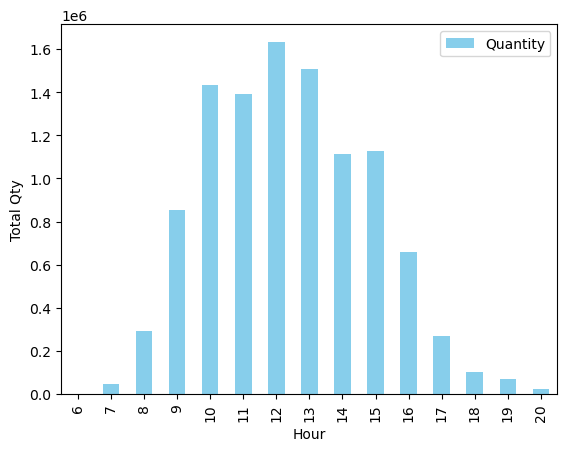

In [20]:
# Showing hourly traffic in a 24hr format
df.groupby('Hour')[['Quantity']].sum().plot(kind='bar', color='skyblue', xlabel='Hour', ylabel='Total Qty')

#We use ['Quantity'] so that the output is a dataframe instead of series so that the label for x axis is shown

<Figure size 1200x600 with 0 Axes>

<BarContainer object of 15 artists>

Text(0.5, 1.0, 'Hourly Inventory Movement (Quantity Sold)')

Text(0.5, 0, 'Hour')

Text(0, 0.5, 'Units Sold')

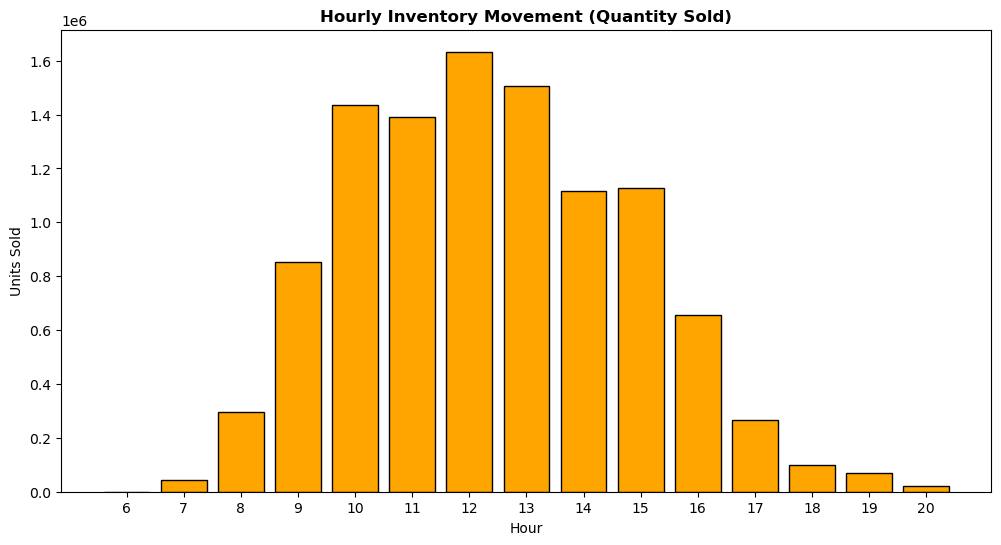

In [21]:
# Using matplotlib instead of pandas for more control over plots

import matplotlib.pyplot as plt

hourly_series=df.groupby('Hour')['Quantity'].sum()

plt.figure(figsize=(12, 6))
plt.bar(hourly_series.index.astype(str), hourly_series.values, color='orange', edgecolor='black')

plt.title('Hourly Inventory Movement (Quantity Sold)', fontweight='bold')
plt.xlabel('Hour')
plt.ylabel('Units Sold')

plt.show()

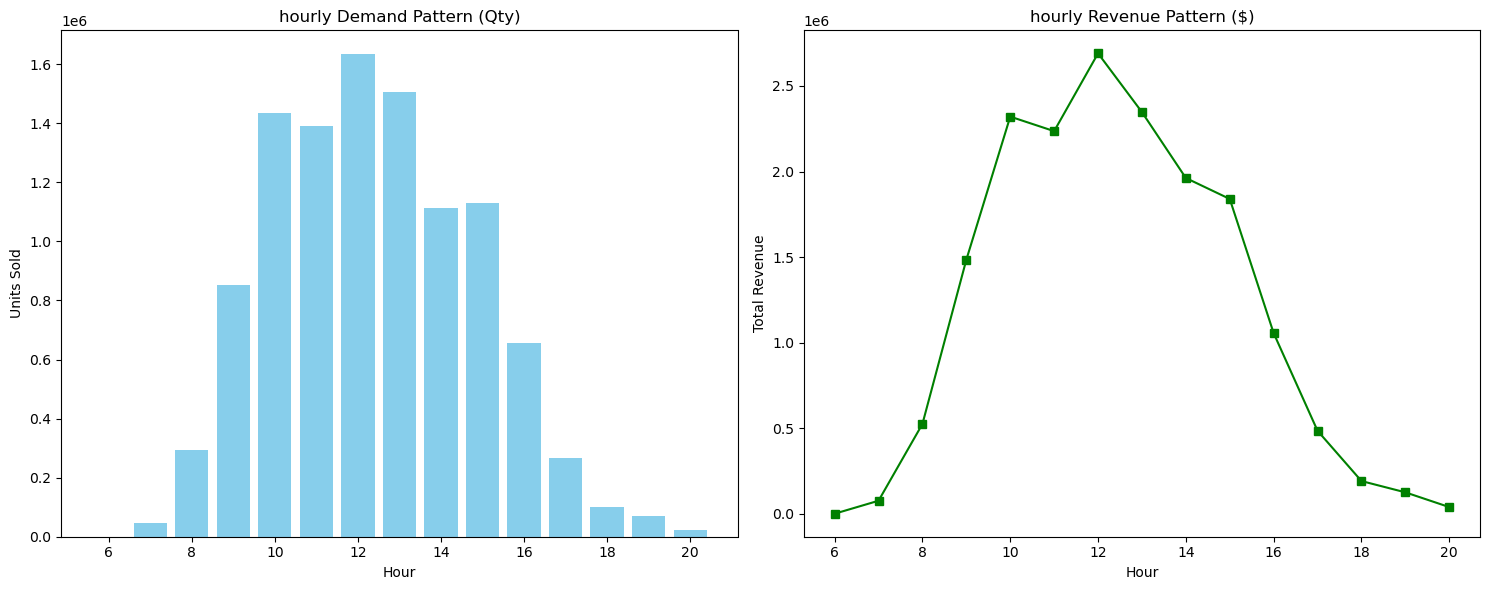

In [22]:
# Create a figure with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Hourly Quantity (Left Axis)
hourly_qty = df.groupby('Hour')['Quantity'].sum()
ax1.bar(hourly_qty.index, hourly_qty.values, color='skyblue')
ax1.set_title('hourly Demand Pattern (Qty)')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Units Sold')

# Plot 2: Hourly Revenue (Right Axis)
hourly_rev = df.groupby('Hour')['Total Line Value'].sum()
ax2.plot(hourly_rev.index, hourly_rev.values, color='green', marker='s')
ax2.set_title('hourly Revenue Pattern ($)')
ax2.set_xlabel('Hour')
ax2.set_ylabel('Total Revenue')

plt.tight_layout() # Prevents labels from overlapping
plt.show(); # ; removes any text outputs

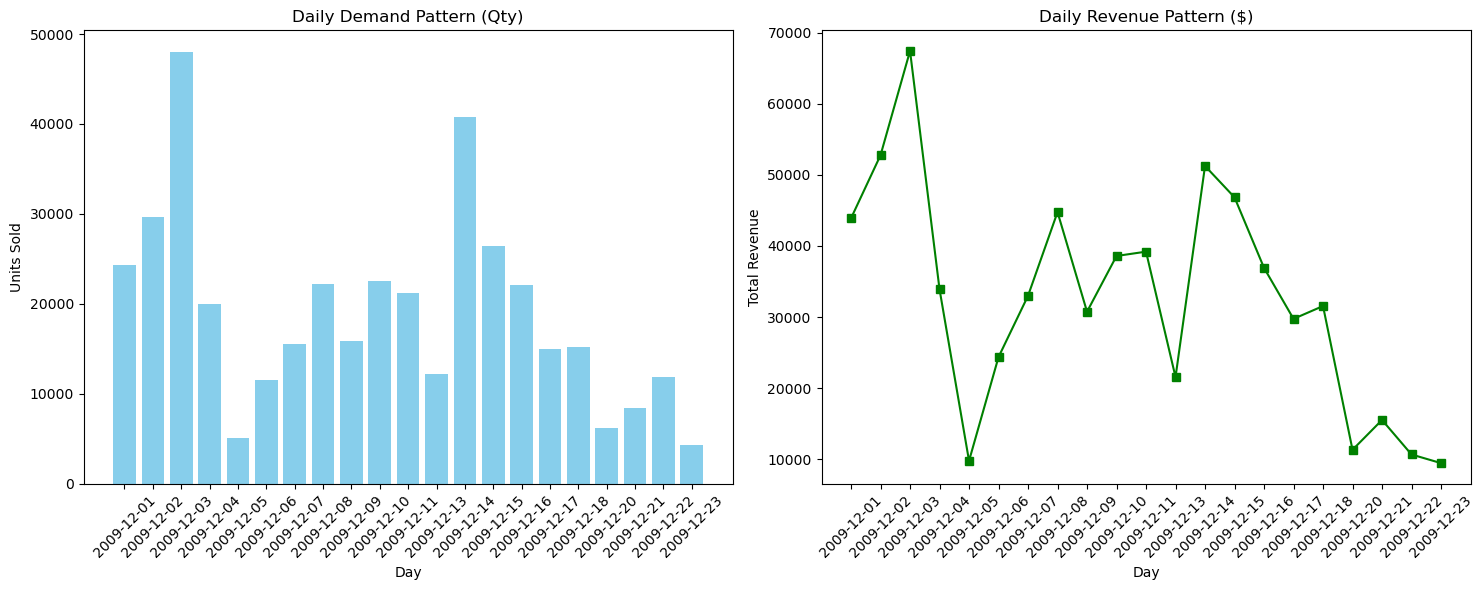

In [23]:
# Filter for December 2009
df_filtered = df[df['Month'] == '2009-12']

# Create a figure with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Hourly Quantity (Left Axis)
daily_qty = df_filtered.groupby('Day')['Quantity'].sum()
ax1.bar(daily_qty.index.astype(str), daily_qty.values, color='skyblue')
ax1.set_title('Daily Demand Pattern (Qty)')
ax1.set_xlabel('Day')
ax1.set_ylabel('Units Sold')

# Plot 2: Hourly Revenue (Right Axis)
daily_rev = df_filtered.groupby('Day')['Total Line Value'].sum()
ax2.plot(daily_rev.index.astype(str), daily_rev.values, color='green', marker='s')
ax2.set_title('Daily Revenue Pattern ($)')
ax2.set_xlabel('Day')
ax2.set_ylabel('Total Revenue')

# Rotate labels for the first subplot
ax1.tick_params(axis='x', rotation=45)

# Rotate labels for the second subplot
ax2.tick_params(axis='x', rotation=45)


plt.tight_layout() # Prevents labels from overlapping

plt.show();

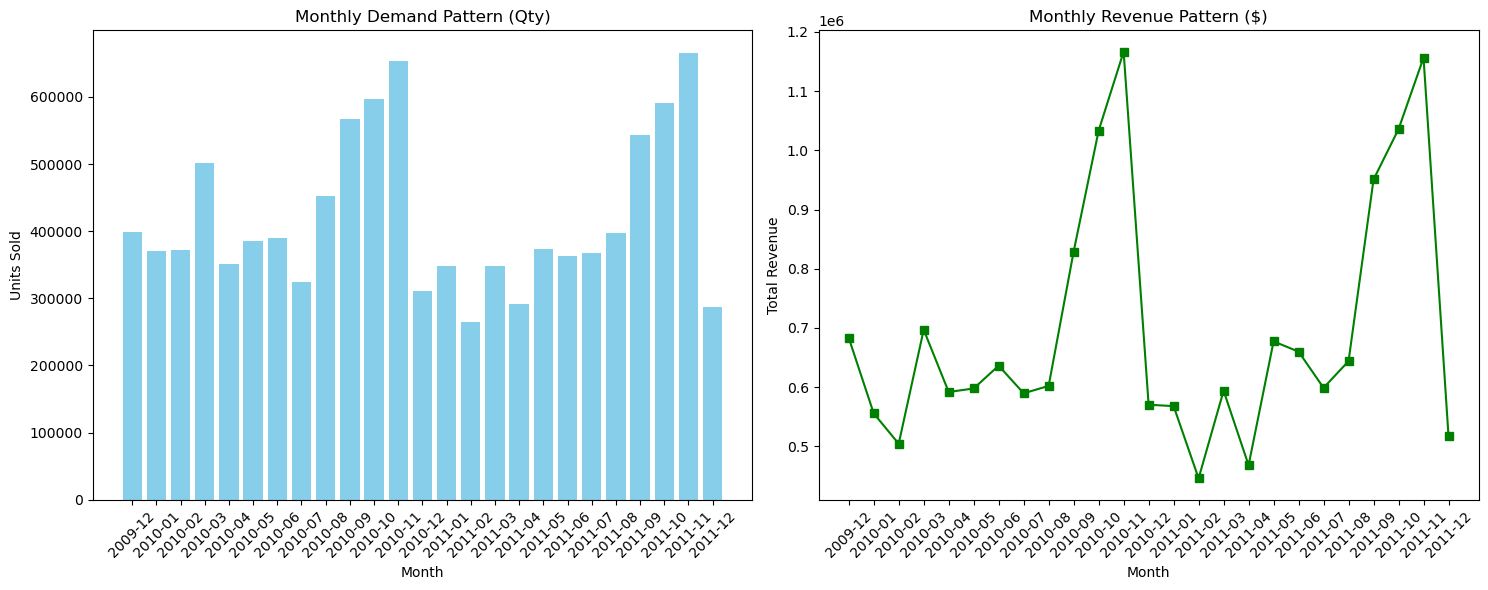

In [24]:
# Create a figure with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Hourly Quantity (Left Axis)
monthly_qty = df.groupby('Month')['Quantity'].sum()
ax1.bar(monthly_qty.index.astype(str), monthly_qty.values, color='skyblue')
ax1.set_title('Monthly Demand Pattern (Qty)')
ax1.set_xlabel('Month')
ax1.set_ylabel('Units Sold')

# Plot 2: Hourly Revenue (Right Axis)
monthly_rev = df.groupby('Month')['Total Line Value'].sum()
ax2.plot(monthly_rev.index.astype(str), monthly_rev.values, color='green', marker='s')
ax2.set_title('Monthly Revenue Pattern ($)')
ax2.set_xlabel('Month')
ax2.set_ylabel('Total Revenue')

# Rotate labels for the first subplot
ax1.tick_params(axis='x', rotation=45)

# Rotate labels for the second subplot
ax2.tick_params(axis='x', rotation=45)


plt.tight_layout() # Prevents labels from overlapping

plt.show();

We can see from our plots that the maximum revenue is during October and 

<Axes: xlabel='Month'>

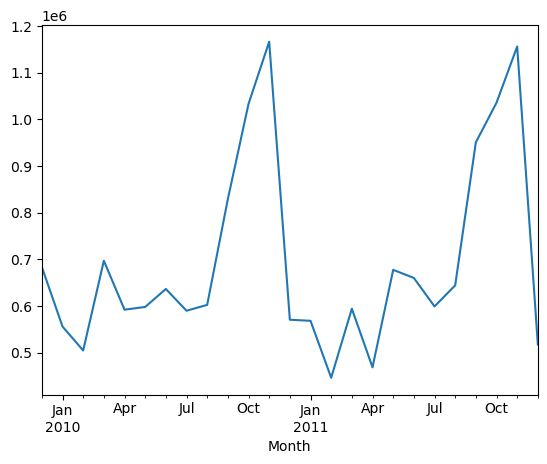

In [25]:
# As we can see, matplotlib provides us with much more customization options
monthly = df.groupby('Month')['Total Line Value'].sum()
monthly.plot()


## <font color='magenta'> 4. PRODUCT ANALYSIS </font>

In [26]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total Line Value,Year,Month,Day,Hour
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,7,13085,United Kingdom,83,2009,2009-12,2009-12-01,7
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,7,13085,United Kingdom,81,2009,2009-12,2009-12-01,7
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,7,13085,United Kingdom,81,2009,2009-12,2009-12-01,7
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2,13085,United Kingdom,101,2009,2009-12,2009-12-01,7
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1,13085,United Kingdom,30,2009,2009-12,2009-12-01,7


In [27]:
# This shows that StockCode is the key to do product analysis
df['StockCode'].nunique()
df['Description'].nunique()

4631

5283

In [28]:
# List of non-product codes to exclude
exclude_codes = ['M', 'POST', 'D', 'DOT']

sales_by_product=df[~df['StockCode'].isin(exclude_codes)].groupby('StockCode')['Quantity'].sum()

print(f"The highest selling product is the StockCode {sales_by_product.idxmax()} with {sales_by_product.max()} units sold")

The highest selling product is the StockCode 84077 with 105185 units sold


In [29]:
rev_by_product=df[~df['StockCode'].isin(exclude_codes)].groupby('StockCode')['Total Line Value'].sum()

print(f"The highest revenue generating product is the StockCode {rev_by_product.sort_values(ascending=False).index[0]} with {rev_by_product.sort_values(ascending=False).iloc[0]} total revenue genrated by it")

The highest revenue generating product is the StockCode 22423 with 277656.25 total revenue genrated by it


In [30]:
df[df['StockCode']=='22423'].sample(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total Line Value,Year,Month,Day,Hour
695831,551291,22423,REGENCY CAKESTAND 3 TIER,16,2011-04-27 14:26:00,11,14298,United Kingdom,175,2011,2011-04,2011-04-27,14
343455,522914,22423,REGENCY CAKESTAND 3 TIER,4,2010-09-17 13:53:00,13,17139,United Kingdom,51,2010,2010-09,2010-09-17,13
746119,556206,22423,REGENCY CAKESTAND 3 TIER,4,2011-06-09 13:46:00,13,14911,Ireland,51,2011,2011-06,2011-06-09,13
437270,531221,22423,REGENCY CAKESTAND 3 TIER,2,2010-11-05 16:27:00,13,12450,Spain,26,2010,2010-11,2010-11-05,16
996833,576639,22423,REGENCY CAKESTAND 3 TIER,1,2011-11-16 09:43:00,13,13894,United Kingdom,13,2011,2011-11,2011-11-16,9


In [31]:
# List of non-product codes to exclude
exclude_codes = ['M', 'POST', 'D', 'DOT']

# Filtered GroupBy for Product Analysis
product_ranking = df[~df['StockCode'].isin(exclude_codes)].groupby('StockCode')['Quantity'].sum()

print(f"The top real product is {product_ranking.idxmax()} with {product_ranking.max()} units.")

The top real product is 84077 with 105185 units.


In [32]:
# Top 20 Revenue generating products with their revenues
print(df[~df['StockCode'].isin(exclude_codes)]
      .groupby('Description')['Total Line Value']
      .sum()
      .sort_values(ascending=False)
      .head(20))

Description
REGENCY CAKESTAND 3 TIER              277,656
WHITE HANGING HEART T-LIGHT HOLDER    247,048
PAPER CRAFT , LITTLE BIRDIE           168,470
JUMBO BAG RED RETROSPOT               134,307
ASSORTED COLOUR BIRD ORNAMENT         124,352
PARTY BUNTING                         103,283
MEDIUM CERAMIC TOP STORAGE JAR         81,417
PAPER CHAIN KIT 50'S CHRISTMAS         76,598
CHILLI LIGHTS                          69,084
JUMBO BAG STRAWBERRY                   64,128
BLACK RECORD COVER FRAME               63,092
ROTATING SILVER ANGELS T-LIGHT HLDR    55,880
WOOD BLACK BOARD ANT WHITE FINISH      54,525
VINTAGE UNION JACK BUNTING             54,433
EDWARDIAN PARASOL NATURAL              54,333
JUMBO  BAG BAROQUE BLACK WHITE         52,188
RABBIT NIGHT LIGHT                     51,251
HEART OF WICKER LARGE                  49,860
RED HANGING HEART T-LIGHT HOLDER       48,851
JUMBO STORAGE BAG SUKI                 47,761
Name: Total Line Value, dtype: float64


## <font color='magenta'> 5. CUSTOMER DESCRIPTIVE ANALYTICS </font>

In [33]:
print(f"Total Unique Customers are {df['Customer ID'].nunique()}")

Total Unique Customers are 5878


In [34]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total Line Value,Year,Month,Day,Hour
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,7,13085,United Kingdom,83,2009,2009-12,2009-12-01,7
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,7,13085,United Kingdom,81,2009,2009-12,2009-12-01,7
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,7,13085,United Kingdom,81,2009,2009-12,2009-12-01,7
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2,13085,United Kingdom,101,2009,2009-12,2009-12-01,7
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1,13085,United Kingdom,30,2009,2009-12,2009-12-01,7


In [35]:
print(f"Total Orders are {df['Invoice'].nunique()}")

Total Orders are 36969


In [36]:
total_reps=df['Customer ID'].value_counts()
new_cust=(total_reps==1).sum()
repeat_cust=(total_reps>1).sum()
print(f"New customers are {new_cust} and repeat customers are {repeat_cust}")

New customers are 115 and repeat customers are 5763


In [37]:
freq=df.groupby('Customer ID')['Invoice'].nunique()
print(freq.head())
freq.describe()

Customer ID
12346    12
12347     8
12348     5
12349     4
12350     1
Name: Invoice, dtype: int64


count   5,878
mean        6
std        13
min         1
25%         1
50%         3
75%         7
max       398
Name: Invoice, dtype: float64

<Axes: xlabel='Customer ID'>

Text(0.5, 1.0, 'Top 20 Customers by Transaction Frequency')

Text(0.5, 0, 'Customer ID')

Text(0, 0.5, 'Number of Invoices')

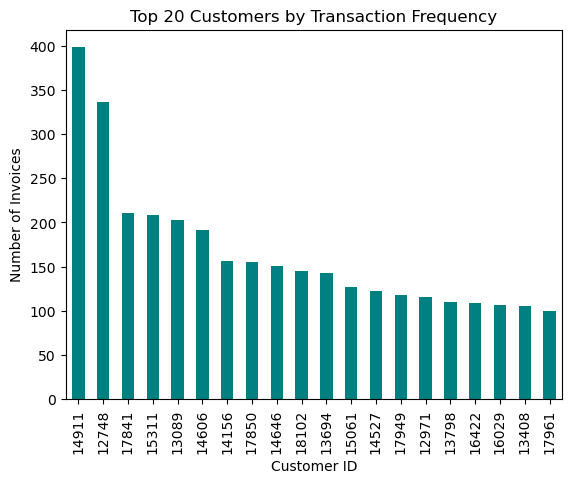

In [38]:
top_20_freq = freq.sort_values(ascending=False).head(20)

top_20_freq.plot(kind='bar', color='teal')

plt.title('Top 20 Customers by Transaction Frequency')
plt.xlabel('Customer ID')
plt.ylabel('Number of Invoices')
plt.show()

In [39]:
# Inter-Purchase Time Analysis

df = df.sort_values(['Customer ID', 'InvoiceDate'])

df['PrevPurchaseDate'] = df.groupby('Customer ID')['InvoiceDate'].shift(1)
df['DaysBetween'] = (df['InvoiceDate'] - df['PrevPurchaseDate']).dt.days

df.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total Line Value,Year,Month,Day,Hour,PrevPurchaseDate,DaysBetween
27994,491725,TEST001,This is a test product.,10,2009-12-14 08:34:00,4,12346,United Kingdom,45,2009,2009-12,2009-12-14,8,NaT,NaN
28251,491742,TEST001,This is a test product.,5,2009-12-14 11:00:00,4,12346,United Kingdom,22,2009,2009-12,2009-12-14,11,2009-12-14 08:34:00,0
28254,491744,TEST001,This is a test product.,5,2009-12-14 11:02:00,4,12346,United Kingdom,22,2009,2009-12,2009-12-14,11,2009-12-14 11:00:00,0
39398,492718,TEST001,This is a test product.,5,2009-12-18 10:47:00,4,12346,United Kingdom,22,2009,2009-12,2009-12-18,10,2009-12-14 11:02:00,3
39411,492722,TEST002,This is a test product.,1,2009-12-18 10:55:00,1,12346,United Kingdom,1,2009,2009-12,2009-12-18,10,2009-12-18 10:47:00,0


In [40]:
df['DaysBetween'].dropna().describe()

count   773,547
mean          2
std          18
min           0
25%           0
50%           0
75%           0
max         714
Name: DaysBetween, dtype: float64

In [41]:
# Displays total revenue per customer - Customer Lifetime Revenue (CLV)
clv=df.groupby('Customer ID')['Total Line Value'].sum().sort_values(ascending=False)

clv.describe()

top_5_pct = clv.head(int(len(clv)*0.05)).sum() / clv.sum()
top_20_pct = clv.head(int(len(clv)*0.20)).sum() / clv.sum()

print(f"Top 20% customers contibute {round(top_20_pct*100)}% and top 5% customers contribute {round(top_5_pct*100)}% to the total revenue.")

count     5,878
mean      2,956
std      14,441
min           3
25%         342
50%         868
75%       2,248
max     580,987
Name: Total Line Value, dtype: float64

Top 20% customers contibute 77% and top 5% customers contribute 52% to the total revenue.


In [42]:
# Customer Recency

ref_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
recency = df.groupby('Customer ID')['InvoiceDate'].max().apply(lambda x: (ref_date - x).days)
recency.describe()


count   5,878
mean      201
std       209
min         1
25%        26
50%        96
75%       380
max       739
Name: InvoiceDate, dtype: float64

In [43]:
# Customer Summary Table

customer_summary = pd.DataFrame({
    'Frequency': freq,
    'Monetary': clv,
    'Recency': recency
}).reset_index()

customer_summary.head()


,Customer ID,Frequency,Monetary,Recency
0,12346,12,"77,556",326
1,12347,8,"4,922",2
2,12348,5,"2,019",75
3,12349,4,"4,429",19
4,12350,1,334,310


### RFM SEGMENTATION

In [53]:
# RFM Setup

ref_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,
    'Invoice': 'nunique',
    'Total Line Value': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

In [55]:
# RFM Scoring

rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'].rank(method='first'), 5, labels=[1,2,3,4,5])



In [56]:
# RFM Segment Creation

def segment_customer(row):
    r,f,m = int(row['R_Score']),int(row['F_Score']),int(row['M_Score'])
    if r>=4 and f>=4 and m>=4: return 'Champion'
    if r>=4 and f>=3: return 'Loyal'
    if f>=4 and m>=4: return 'Big Spender'
    if r<=2 and f>=3: return 'At Risk'
    if r<=2 and f<=2: return 'Lost'
    return 'Others'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)


In [57]:
rfm_seg_summary = rfm.groupby('Segment').agg({
    'CustomerID':'count',
    'Monetary':'mean',
    'Recency':'mean',
    'Frequency':'mean'
}).sort_values('CustomerID', ascending=False)

rfm_seg_summary

,CustomerID,Monetary,Recency,Frequency
Segment,,,,
Lost,1523,430,459,1
Champion,1297,"9,144",20,17
Others,1206,850,81,2
Big Spender,627,"4,121",188,9
Loyal,624,"1,032",24,4
At Risk,601,"1,010",379,3


In [58]:
rfm.to_csv('rfm_segments.csv', index=False)

### COHORT RETENTION

In [ ]:
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')
first_month = df.groupby('Customer ID')['InvoiceMonth'].min()
df = df.merge(first_month.rename('CohortMonth'), on='Customer ID')

In [72]:
df['CohortIndex'] = (df['InvoiceMonth'] - df['CohortMonth']).apply(lambda x: x.n)

cohort_data = df.groupby(['CohortMonth','CohortIndex'])['Customer ID'].nunique().reset_index()
cohort_pivot = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='Customer ID')
retention = cohort_pivot.div(cohort_pivot.iloc[:,0], axis=0)

retention.to_csv('cohort_retention.csv')


In [74]:
clv = df.groupby('Customer ID')['Total Line Value'].sum().reset_index(name='CLV')
clv.to_csv('clv_basic.csv', index=False)


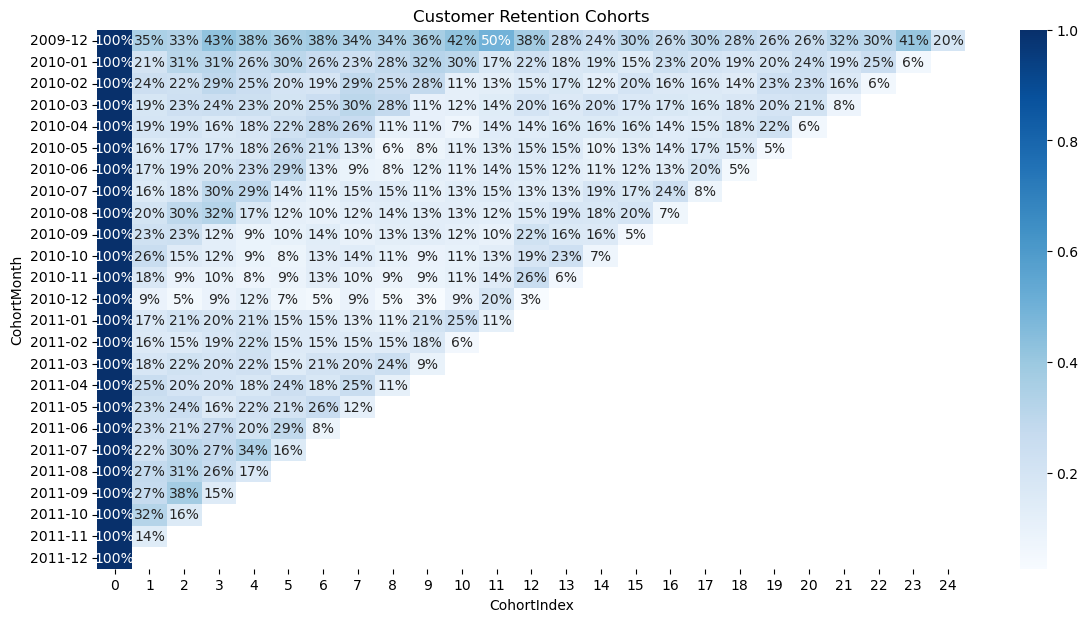

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14,7))
sns.heatmap(retention, annot=True, fmt='.0%', cmap='Blues')
plt.title('Customer Retention Cohorts')
plt.show();
